In [8]:
from diffusers import DiffusionPipeline
model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
pipeline = pipeline.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from transparent_background import Remover

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
image_url = 'https://raw.githubusercontent.com/prtm1908/photo-background-generation/master/Screenshot%202024-09-18%20013614.jpg'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = resize_with_padding(img, (512, 512))

# Load background detection model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(img, type='map') # default setting - transparent background


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


  0%|          | 0/20 [00:00<?, ?it/s]

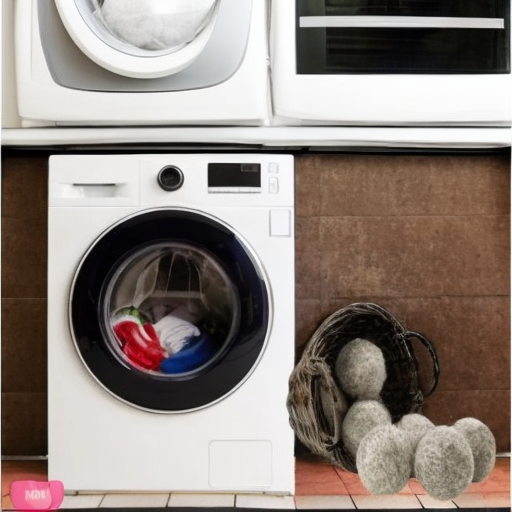

In [18]:
import torch
seed = 13
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device='cuda').manual_seed(seed)
prompt = 'basket containing wool dryer balls in front of a washing machine'
cond_scale = 1.0
with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale
    ).images[0]
controlnet_image